In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math
import h5py
# import healpy as hp
import pykdgrav3_utils
from pykdgrav3_utils import units
un = units.units(1, 600., verbose=True)
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from matplotlib.projections.geo import GeoAxes

sys.path.append('/home/dnurme/linux_env/Thesis/My_thesis/Modules/')
from mock_wake import generate_mock_wake
from rotation_funcs import rotate, angle_finder, rz, ry, rx
from misc import plot_OD_gaussian

dMsolUnit = 1.000000e+00
dKpcUnit = 6.000000e+02
dGasConst =  1150890.1952769116
dErgPerGmUnit =  71.68174956254887
dGmPerCcUnit =  3.1333829769061664e-40
dSecUnit =  2.1867420491060357e+23
dKmPerSecUnit =  8.466507518602276e-05
dComovingGmPerCcUnit =  3.1333829769061664e-40


In [2]:
file = '/home/dnurme/linux_env/Data/dm_sim.00001.0'

def load_snap_file(path, part_type='PartType1', is_print = False):

    snap_file = h5py.File(path, 'r')
    part_data = snap_file[part_type]

    if(is_print):
        print(f'Loading snapshot: {path.split("/")[-1]}')
        print(f'Selected species: {part_type}')
        print(f'Snap file keys: {snap_file.keys()}')
        print(f'Part type keys: {part_data.keys()}')

    return part_data

In [3]:
## Find LMC velocity when it is at 70 kpc distance. Also find its current position.

orbitfile = '/home/dnurme/linux_env/Data/trajlmc.txt'
orbit_full = pd.read_csv(orbitfile, delimiter = ' ')
orbit = orbit_full.loc[np.where(orbit_full['time'] < 0.01)]
d_orbit = np.sqrt(orbit['x']**2 + orbit['y']**2 + orbit['z']**2)
loc70 = np.isclose(d_orbit, 70.0, 0.01)
# 70 - d_orbit[loc70]
v70 = orbit['Vx'][loc70].values[0], orbit['Vy'][loc70].values[0], orbit['Vz'][loc70].values[0]
LMC_70 = np.array([orbit['x'][loc70].values[0], orbit['y'][loc70].values[0], orbit['z'][loc70].values[0]])

LMC_today = np.isclose(orbit['time'], 0.0, 0.001)
LMC_loc_today = np.array([orbit['x'][LMC_today].values[0], orbit['y'][LMC_today].values[0], orbit['z'][LMC_today].values[0]])


In [4]:
snap_stars = load_snap_file(file, part_type='PartType4', is_print=True)
star_coord = snap_stars['Coordinates'][:]*un.dKpcUnit

Loading snapshot: dm_sim.00001.0
Selected species: PartType4
Snap file keys: <KeysViewHDF5 ['Cosmology', 'Header', 'Parameters', 'PartType1', 'PartType4', 'Units']>
Part type keys: <KeysViewHDF5 ['Coordinates', 'GroupID', 'Masses', 'ParticleIDs', 'Potential', 'Softening', 'StellarFormationTime', 'Velocities']>


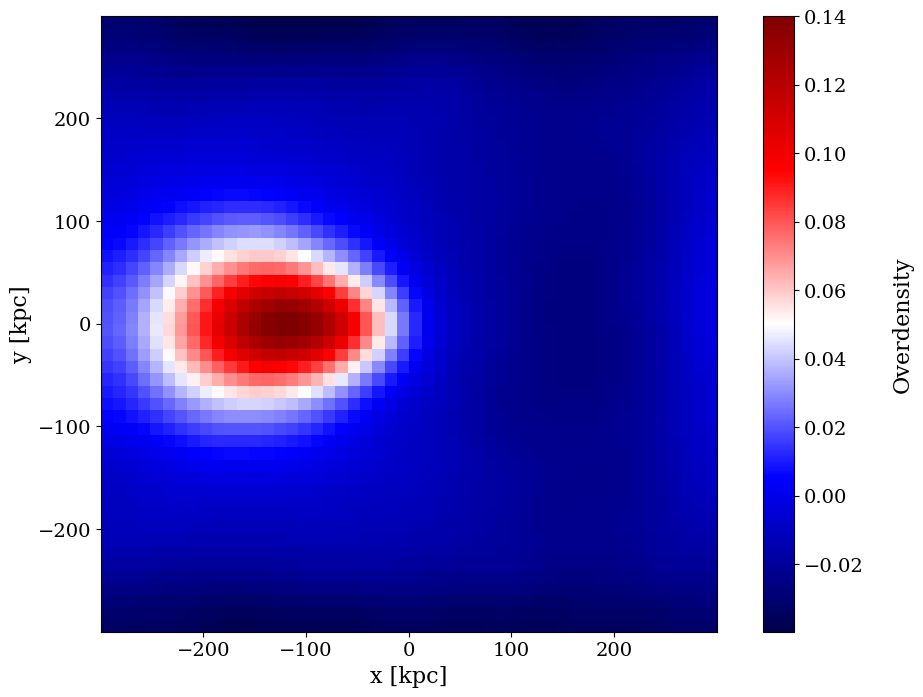

In [5]:
x = star_coord[:,0]
y = star_coord[:,1]

plot_OD_gaussian(x, y, (50, 50), 2, 'x [kpc]', 'y [kpc]')

In [6]:
## Rotate simulation

z_angle, y_angle = angle_finder(v70)

R = rz(np.radians(z_angle)) @ ry(np.radians(y_angle))
star_coord_rot = R @ star_coord.T
star_coord_rot = star_coord_rot.T


Rz = -98.38192060960003, Ry = -5.918706233387963


In [7]:
del snap_stars
del star_coord

In [8]:
## Find perpendicular and parallel distances

a = (LMC_loc_today - LMC_70)
v_n = v70 / np.linalg.norm(v70)

d_par = np.dot(a, v_n)*v_n
d_perp = a - d_par

In [9]:
star_coord_rot += LMC_loc_today 
star_coord_rot -= d_perp


In [10]:
dist_mask = np.sqrt(star_coord_rot[:,0]**2 + star_coord_rot[:,1]**2 + star_coord_rot[:,2]**2)
masked_LMC = star_coord_rot[np.where((dist_mask > 70) & (dist_mask < 100))]

In [11]:
# plt.hist2d(star_coord_rot[:,0][::100], star_coord_rot[:,1][::100], bins=50, cmap='viridis')
# plt.hist2d(LMC_sim_pos[:,0][::100], LMC_sim_pos[:,1][::100], bins=50, cmap='viridis')
#plt.hist2d(masked_LMC[:,0], masked_LMC[:,1], bins=64, cmap='viridis')

In [12]:
# LMC_sky = SkyCoord(masked_LMC[:,0], 
#                    masked_LMC[:,1], 
#                    masked_LMC[:,2], 
#                    frame = 'galactocentric', 
#                    unit='kpc', 
#                    representation_type='cartesian')

# LMC_orbit = SkyCoord(orbit['x'], 
#                      orbit['y'], 
#                      orbit['z'], 
#                      frame = 'galactocentric', 
#                      unit='kpc', 
#                      representation_type='cartesian')

# full_orbit = SkyCoord(orbit_full['x'],
#                      orbit_full['y'], 
#                      orbit_full['z'], 
#                      frame = 'galactocentric', 
#                      unit='kpc', 
#                      representation_type='cartesian')

LMC_sky = SkyCoord(masked_LMC[:,0], 
                   masked_LMC[:,1], 
                   masked_LMC[:,2], 
                   frame = 'galactocentric', 
                   unit='kpc', 
                   representation_type='cartesian')

LMC_orbit = SkyCoord(orbit['x'], 
                     orbit['y'], 
                     orbit['z'], 
                     frame = 'galactocentric', 
                     unit='kpc', 
                     representation_type='cartesian')

LMC_location_today = SkyCoord(LMC_loc_today[0], 
                         LMC_loc_today[1], 
                         LMC_loc_today[2], 
                         frame = 'galactocentric', 
                         unit='kpc', 
                         representation_type='cartesian')



In [13]:
# nside = 64

# gal_l = LMC_sky.galactic.l.wrap_at(180 * u.deg)
# gal_b = LMC_sky.galactic.b

# lon = gal_l.radian
# lat = gal_b.radian

# theta = 0.5 * np.pi - lat
# phi = lon % (2 * np.pi)

# pix = hp.ang2pix(nside, theta, phi)
# m = np.bincount(pix, minlength=hp.nside2npix(nside)).astype(float)


In [14]:
# hp.mollview(m, unit='stars', cmap='viridis', title='Hernquist Profile DM LMC Mollweide projection', cbar=True)
# hp.graticule()

In [15]:
# projview(
#     m, 
#     unit = 'stars', 
#     cmap = 'seismic', 
#     title='Hernquist Profile DM LMC Mollweide projection', 
#     graticule=True, 
#     graticule_labels=True, 
#     projection_type="mollweide",
#     xlabel='Galactic Longitude',
#     ylabel='Galactic Latitude',
# );
# plt.plot(-LMC_orbit.galactic.l.wrap_at(180 * u.deg).radian, LMC_orbit.galactic.b.radian, 'k-', markersize=0.5)
# # plt.plot(-full_orbit.galactic.l.wrap_at(180 * u.deg).radian, full_orbit.galactic.b.radian, 'k-', markersize=0.5)

/tmp/ipykernel_88882/3763926758.py:25: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  delta_sm = hp.smoothing(delta, fwhm=fwhm, verbose=False)


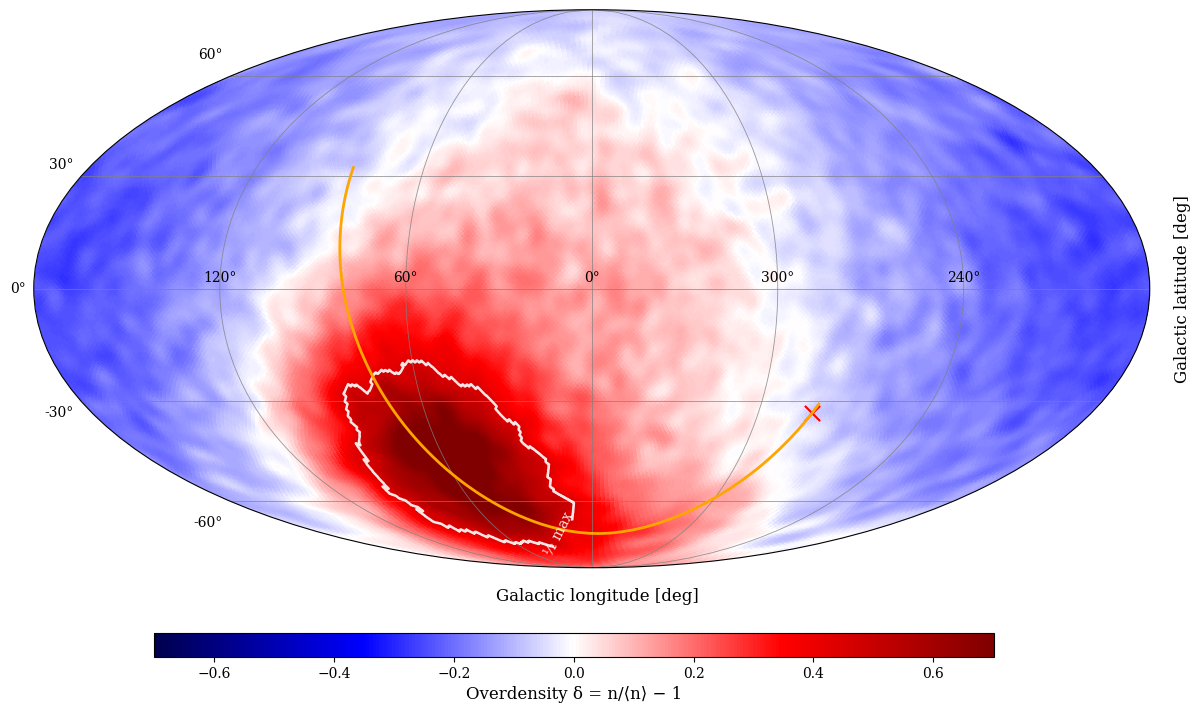

In [ ]:
# Healpy osa
nside = 64

gal_l = LMC_sky.galactic.l.wrap_at(180 * u.deg)
gal_b = LMC_sky.galactic.b

lon = gal_l.radian
lat = gal_b.radian

theta = 0.5*np.pi - lat                # latitude -> colatitude
phi   = lon % (2*np.pi)                # wrap to [0, 2π)

pix = hp.ang2pix(nside, theta, phi)
m = np.bincount(pix, minlength=hp.nside2npix(nside)).astype(float)

# Overdensity osa
pop = m > 0
mu  = m[pop].mean() if np.any(pop) else 1.0

delta = np.full_like(m, hp.UNSEEN, dtype=float)
delta[pop] = (m[pop] / mu) - 1.0

# Smoothing funktsioon, proovi ilma selleta! See 5 on siin suvaline, seda peab vaatama veel. 
fwhm = np.radians(5)
delta_sm = hp.smoothing(delta, fwhm=fwhm, verbose=False)

# Healpy -> Matplib toimub siin
def project_healpy_to_plt(nside, xsize=2000):
    """Return (grid_pix, xsize, ysize) for Matplotlib Mollweide plotting."""
    ysize = xsize // 2                   # Mollweide aspect 2:1
    theta_grid = np.linspace(np.pi, 0, ysize)
    phi_grid   = np.linspace(-np.pi, np.pi, xsize)
    PHI, THETA = np.meshgrid(phi_grid, theta_grid)
    grid_pix   = hp.ang2pix(nside, THETA, PHI)
    return grid_pix, xsize, ysize

# Pmst. milline healpy pixel iga matplotlibi pikslile vastab
grid_pix, xsize, ysize = project_healpy_to_plt(nside)
grid_map = delta_sm[grid_pix]           # fancy indexing -> (ysize, xsize)

longitude = np.radians(np.linspace(-180, 180, xsize))
latitude  = np.radians(np.linspace(-90,   90, ysize))

# Korrastab ticke
class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shift labels from (-180,180) → (0–360) and flip sign for astro convention."""
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)

#
# Siin on alles plottimine
#

fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection="mollweide")

# Neid vmin/vmax väärtusi võib vajaduse muuta, Foote-is on -0.4 kuni 1.0
valid = np.isfinite(grid_map)
vmax = np.nanpercentile(grid_map[valid], 99)
vmax = float(max(vmax, 0.1))            # avoid zero; adjust as needed
vmin = -vmax

# Plot map; reverse longitude to keep east-to-the-left astronomy convention
image = ax.pcolormesh(
    longitude[::-1], latitude, grid_map,
    vmin=vmin, vmax=vmax,
    cmap="seismic", rasterized=True,
)

halfmax = 0.5 * np.nanmax(grid_map[valid])

cont = ax.contour(
    longitude[::-1], latitude, grid_map,
    levels=[halfmax], colors='white', linewidths=1.8,
    linestyles='solid', alpha=0.9
)
ax.clabel(cont, fmt={halfmax: '½ max'}, inline=True, fontsize=10, colors='white')

# Orbit overlays (Matplotlib expects radians here)
# LMC orbiit
ax.plot(
    -LMC_orbit.galactic.l.wrap_at(180*u.deg).radian,
     LMC_orbit.galactic.b.radian,
     color='orange', lw=2, label='LMC orbit', 
     zorder = 2
)

# LMC tänane asukoht
ax.scatter(
    -LMC_location_today.galactic.l.wrap_at(180*u.deg).radian,
     LMC_location_today.galactic.b.radian,
     marker='x', color='red', s=120, label='LMC today (SIMBAD)',
     zorder = 3
)

# Grid and tick labels
ax.grid(True, color="gray", lw=0.6, alpha=0.8)
ax.set_longitude_grid(60)
ax.set_latitude_grid(30)
ax.set_longitude_grid_ends(90)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi(60))
ax.tick_params(axis='x', labelsize=10, colors='black')
ax.tick_params(axis='y', labelsize=10, colors='black')

# Colorbar
cax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
cb = fig.colorbar(image, cax=cax, orientation="horizontal")
cb.set_label("Overdensity δ = n/⟨n⟩ − 1", fontsize=12)
cb.solids.set_edgecolor("face")

# Axis labels
plt.figtext(0.52, 0.15, "Galactic longitude [deg]", ha="center", fontsize=12)
plt.figtext(1.00, 0.54, "Galactic latitude [deg]",  va="center", rotation=90, fontsize=12)

plt.subplots_adjust(bottom=0.1, top=0.98, left=0.05, right=0.98)
plt.show()


In [35]:
r_a = 20.0
mass_LMC = 1.8 * 1e11
r = list(range(1, 100))
r = np.array(r)


In [36]:
hernquist_density = (mass_LMC / (2 * np.pi)) * (r_a / (r * (r + r_a)**3))

Text(0.5, 0, 'Radius [kpc]')

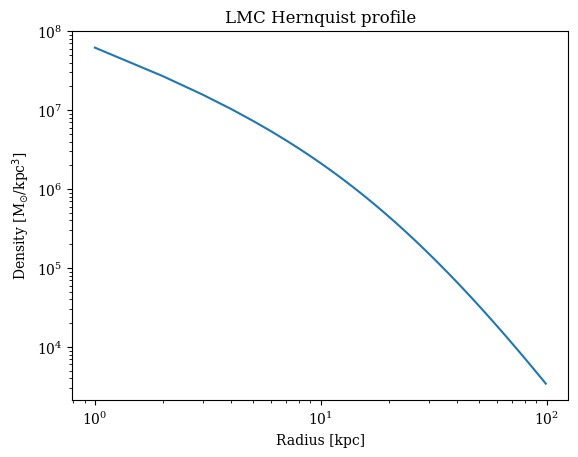

In [37]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plt.plot(r, hernquist_density)
plt.title('LMC Hernquist profile')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'Density [M$_{\odot}$/kpc$^3$]')
plt.xlabel('Radius [kpc]')